# Titanic

## 1. 读取数据

In [9]:
import pandas as pd
import os

filepath = '.'
filename = 'train.csv'

def load_titanic_data(path=filepath,filename=filename):
    '''
    读取一个csv,
    返回df
    '''
    fullpath = os.path.join(filepath,filename)
    return pd.read_csv(fullpath)

In [10]:
df_raw = load_titanic_data()
df_raw.sample(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
784,785,0,3,"Ali, Mr. William",male,25.00,0,0,SOTON/O.Q. 3101312,7.0500,NaN,S
794,795,0,3,"Dantcheff, Mr. Ristiu",male,25.00,0,0,349203,7.8958,NaN,S
831,832,1,2,"Richards, Master. George Sibley",male,0.83,1,1,29106,18.7500,NaN,S
564,565,0,3,"Meanwell, Miss. (Marion Ogden)",female,NaN,0,0,SOTON/O.Q. 392087,8.0500,NaN,S
490,491,0,3,"Hagland, Mr. Konrad Mathias Reiersen",male,NaN,1,0,65304,19.9667,NaN,S


各个维度意义说明:<BR>
- PassengerId: 单样本唯一标识      （无意义 去除）
- Survived: Survival	0 = No, 1 = Yes 目标变量
- Pclass: Ticket class	1 = 1st, 2 = 2nd, 3 = 3rd
- Sex: sex
- Age: age in years
- SibSp: of siblings / spouses aboard the Titanic
- Parch: of parents / children aboard the Titanic
- Ticket: Ticket number   （无意义去除）
- fare: Passenger fare
- Cabin: Cabin number   (无意义去除)
- embarked: Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton

In [11]:
df_train = df_raw.copy()
df_train_raw = df_train.drop(['PassengerId','Name','Ticket','Cabin'],axis=1) #drop会产生一个数据复本，不会影响df_train
df_train_raw.head(5)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


## 2.数据清洗 & 数据预处理

In [14]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


- 可以看到age, Cabin, Embarked是有缺失值的，但Cabin已被删去，所以只需要填充AGE和Embarked的缺失就可以
- 考虑看一下age的分布

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

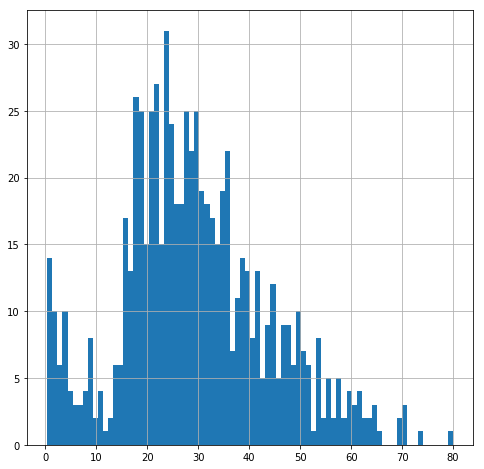

In [16]:
# fig = plt.figure(figsize=(10,10))
df_train_raw.Age.hist(bins=80, figsize=(8,8))

- 可以看到比0岁大一些有10多个<br>
- age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5
- 为了剔除0岁婴儿的影响，fillna取中位数

In [17]:
df_train_raw.Embarked.value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

- EMbarked用众数填充

In [18]:
# 为了后面数据清洗转换方便，把df_train_raw划分为Num和Cat
df_train_num = df_train_raw[['Age','SibSp','Parch','Fare']]
df_train_cat = df_train_raw[['Pclass','Sex','Embarked']]

In [19]:
try:
    from sklearn.compose import ColumnTransformer
except ImportError:
    from future_encoders import ColumnTransformer # Scikit-Learn < 0.20
try:
    from sklearn.impute import SimpleImputer # Scikit-Learn 0.20+
except ImportError:
    from sklearn.preprocessing import Imputer as SimpleImputer

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import  StandardScaler,OneHotEncoder
from sklearn.base import BaseEstimator,TransformerMixin

# class DataFrameSelector(BaseEstimator,TransformerMixin):
#     def __init__(self, attribute_names):
#         self.attribute = attribute_names
#     def fit(self, X, y = None):
#         return self
#     def transform(self,X):
#         return X[self.attribute].values

# 维度名称列表
num_attribs = list(df_train_num)
cat_attribs = list(df_train_cat)

num_pipeline = Pipeline([
#     ('selector',DataFrameSelector(num_attribs)),
    ('imputer',SimpleImputer(strategy = 'median')),
    ('std_scaler',StandardScaler()),
])
cat_pipeline = Pipeline([
#     ('selector',DataFrameSelector(cat_attribs)),
    ('imputer',SimpleImputer(strategy = 'most_frequent')),
    ('label_binarizer', OneHotEncoder()),
])

full_pipeline = ColumnTransformer([
    ('num_pipeline',num_pipeline,num_attribs),
    ('cat_pipeline',cat_pipeline,cat_attribs),
])

In [20]:
np_train_prepared = full_pipeline.fit_transform(df_train_raw)
np_train_prepared

array([[-0.56573646,  0.43279337, -0.47367361, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.66386103,  0.43279337, -0.47367361, ...,  1.        ,
         0.        ,  0.        ],
       [-0.25833709, -0.4745452 , -0.47367361, ...,  0.        ,
         0.        ,  1.        ],
       ..., 
       [-0.1046374 ,  0.43279337,  2.00893337, ...,  0.        ,
         0.        ,  1.        ],
       [-0.25833709, -0.4745452 , -0.47367361, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.20276197, -0.4745452 , -0.47367361, ...,  0.        ,
         1.        ,  0.        ]])

In [21]:
np_train_labels = df_train_raw['Survived'].values
np_train_labels

array([0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1,
       1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0,
       0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 1,

### 小结
- 处理缺失值，然后对于数值型和分类型数据进行划分，分别进行数据处理，数值型用中位数填充，分类型用众数填充
- 数值型:数据标准化
- 分类型:OneHot编码
- 在具体操作方面需要补充

## 3.训练模型
分为三个部分<br>
- 单一模型
- 集成方法 
- 模型性能比较

### 单一模型

#### 随机森林

- 还不会用过多的模型去选择，先用rf去fit
- 网格搜索和随机搜索分别去查找最好的超参数
- 如何用类似配置流程去调整参数？？？

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV

param_grid1 = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators':[3,10,30],'max_features':[2,4,6,8]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap':[False],'n_estimators':[3,10],'max_features':[2,3,4]},
]

forest_cla = RandomForestClassifier(min_samples_split=100,
                                  min_samples_leaf=20,max_depth=10,max_features='sqrt' ,random_state=42)

grid_search = GridSearchCV(forest_cla, param_grid=param_grid1,cv=10,
                          scoring = 'roc_auc',return_train_score = True)

grid_search.fit(np_train_prepared,np_train_labels)
grid_search.best_params_
grid_search.best_score_
print(grid_search.best_params_,grid_search.best_score_)

{'bootstrap': False, 'max_features': 4, 'n_estimators': 10} 0.86226958332


/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [ ]:
from scipy.stats import randint

param_grid2 = {
        'n_estimators': randint(low=1, high=100),
        'max_features': randint(low=1, high=10),
    }
rdm_search = RandomizedSearchCV(forest_cla, param_distributions=param_grid2,cv=10,
                                scoring = 'roc_auc',return_train_score = True ,n_iter=1000)

rdm_search.fit(np_train_prepared,np_train_labels)
print(rdm_search.best_params_,rdm_search.best_score_)

{'max_features': 3, 'n_estimators': 63} 0.855305879565


/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


#### SVM

In [ ]:
from sklearn.svm import SVC
import numpy as np

# 网格搜索
# 设定搜索参数：
param_grid_svc = [
    {'kernel':['poly'],'gamma':np.logspace(-3, 3, 5),'C':np.logspace(-2, 3, 5)},
]
rbf_kernel_svm_clf = SVC()
grid_search_svm = GridSearchCV(rbf_kernel_svm_clf, param_grid=param_grid_svc,cv=10,
                          scoring = 'roc_auc',return_train_score = True)
grid_search_svm.fit(np_train_prepared,np_train_labels)
print(grid_search_svm.best_params_)

#### 神经网络

### 集成模型

### 模型性能比较

In [ ]:
# CROSS_VAL_PREDICT
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

np_train_labels_pred = cross_val_predict(grid_search_svm.best_estimator_,np_train_prepared,np_train_labels, cv=10)
confusion_matrix(np_train_labels,np_train_labels_pred)

### 小结
- 还需要研究！！！
- 网格搜索是给出所有的可能
- 随机是迭代

---

## 4.测试数据

In [ ]:
df_test_raw = load_titanic_data('.','test.csv')
df_test_raw.info()

可以看到AGE和FARE需要缺失值填充

In [ ]:
# df_train = df_raw.copy()
# df_train_raw = df_train.drop(['PassengerId','Name','Ticket','Cabin'],axis=1) #drop会产生一个数据复本，不会影响df_train

df_test = df_test_raw.copy()
df_test_drop = df_test.drop(['PassengerId','Name','Ticket','Cabin'],axis=1)
df_test_drop.head()

In [ ]:
# df_test_num = df_test_drop[['Age','SibSp','Parch','Fare']]
# df_test_cat = df_test_drop[['Pclass','Sex','Embarked']]

np_test_prepared = full_pipeline.fit_transform(df_test_drop)
np_test_prepared

#### 预测

In [ ]:
final_model = grid_search_svm.best_estimator_
final_prediction = final_model.predict(np_test_prepared)
final_prediction

## 5.试验结果转换成submission格式

In [ ]:
num_list = range(892,1310)
result_list = final_prediction.tolist()
df_submission = pd.DataFrame({'PassengerId':num_list,'Survived':result_list})
df_submission.head()

In [ ]:
df_submission.to_csv ("gender_result_2019415.csv" , encoding = "utf-8",index=None)